<h1 align='center'>Projeto de Compensador por LGR<h1>

In [1]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

# Configurações de plot:
plt.style.use([
    'grid',
    'retro'
])
#plt.rcParams['lines.linewidth'] = 3
#plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (12, 5)

<h3 align='center'>Função de Transferência do Sistema:<h3>

In [2]:
s = ct.tf('s')

G = (0.37/(s*((10*s)+1)))

G

TransferFunction(array([0.37]), array([10,  1,  0]))

<h3 align='center'>Definição do polo desejado:<h3>

In [3]:
pd = np.complex_(-0.07+0.07j)

pd

(-0.07+0.07j)

##### $$\text{Atender as condições angular e de módulo do LGR:}$$ $$\phase{C(s)G(s)} = \pm180^\circ(2k+1) ~~\text{e}~~ |C(s)G(s)| = 1$$

In [4]:
def matchLGR(zero, sys, point):
    #Somatórios dos ângulos dos polos e zeros do sistema em relação ao polo desejado:
    gsum = np.sum(np.concatenate([(np.degrees(np.arctan2((point.imag-sys.zeros().imag), (point.real-sys.zeros().real)))), -(np.degrees(np.arctan2((point.imag-sys.poles().imag), (point.real-sys.poles().real))))]))

    #Módulo do sistema avaliado no polo desejado:
    D = sys.den[0][0]
    N = sys.num[0][0]
    A = np.empty(len(D), dtype=np.complex_)
    for i in range(len(D)):
        A[i] = np.power(point, (len(D)-i-1))
    B = np.empty(len(N), dtype=np.complex_)
    for i in range(len(N)):
        B[i] = np.power(point, (len(N)-i-1))

    #Condição angular:
    theta = np.abs((np.degrees(np.arctan2(point.imag, (point.real+zero))) + gsum + 180)) 
    p = ((point.imag/np.tan(np.radians(theta)))-point.real)

    #Condição modular:
    k = (1/np.abs((np.sum(N*B)*(point+zero))/(np.sum(D*A)*(point+p))))
    
    return (zero, p, k)

<h3 align='center'>Varredura nos valores para z:<h3>

C:\Users\Erick\AppData\Local\Temp\ipykernel_19028\658374817.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  ev.append(1/ct.dcgain(ct.minreal((s*L), verbose=False)))


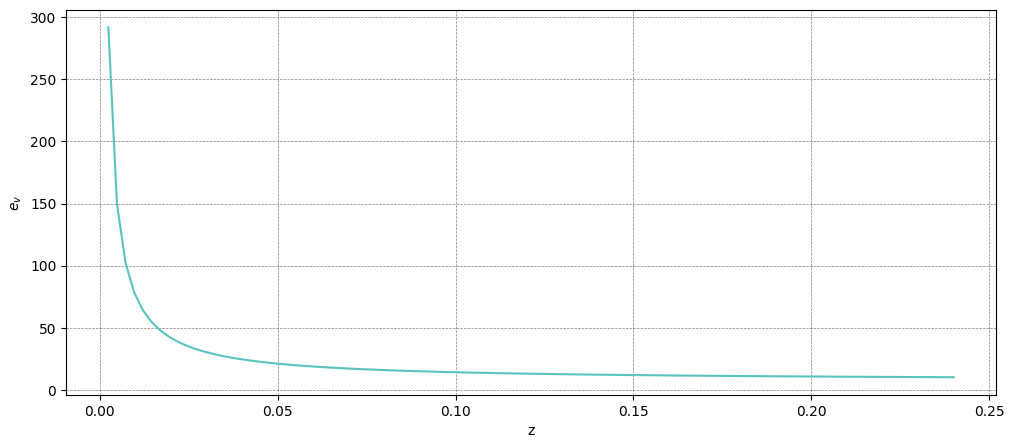

In [5]:
#Valores de z a serem testados:
zvals = np.linspace(0, 0.24, 100)

#Criando as listas para os dados:
ev = []
pvals = []
kvals = []

#Loop para varredura de valores z:
for z in zvals:
    #Cálculo dos parâmetros do controlador:
    z,p,k = matchLGR(z, G, pd)
    #Salvando os dados nas listas:
    pvals.append(p)
    kvals.append(k)
    #Ramo direto e erro de velocidade:
    L = (k*((s+z)/(s+p))*G)
    ev.append(1/ct.dcgain(ct.minreal((s*L), verbose=False)))
#Convertendo os arrays para plot:
ev = np.array(ev)
pvals = np.array(pvals)
kvals = np.array(kvals)

#Plot da curva:
plt.figure()
plt.plot(zvals, ev, color='C2')
plt.ylabel('$e_v$')
plt.xlabel('z')
plt.show()

<h3 align='center'>Comportamento dos demais parâmetros do controlador:<h3>

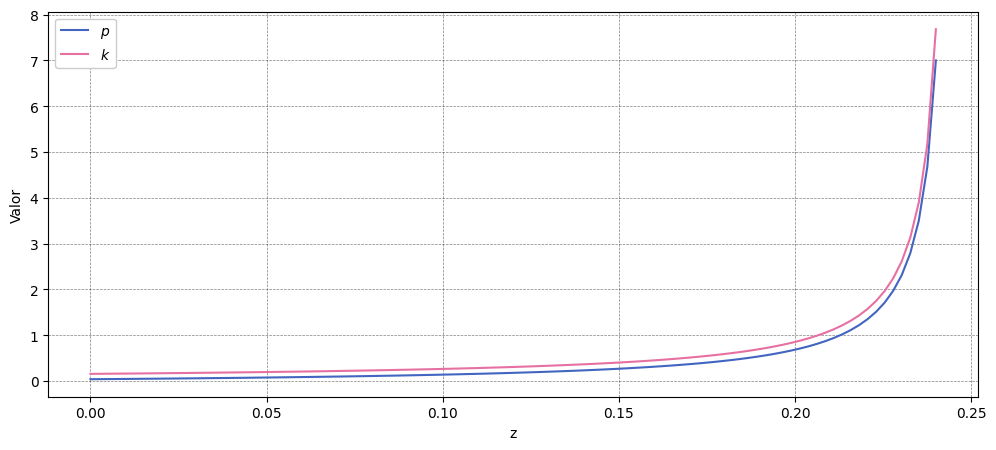

In [6]:
#Plot da curva:
plt.figure()
plt.plot(zvals, pvals, label='$p$')
plt.plot(zvals, kvals, label='$k$')
plt.ylabel('Valor')
plt.xlabel('z')
plt.legend()
plt.show()

<h3 align='center'>Controlador definido:<h3>

In [33]:
z,p,k = matchLGR(0.2, G, pd)

C = (k*((s+z)/(s+p)))
C

TransferFunction(array([0.85345345, 0.17069069]), array([1.        , 0.68444444]))

<h3 align='center'>Polos da malha fechada:<h3>

In [34]:
mf = ct.feedback(C*G)

ct.poles(mf)

array([-0.64444444+0.j  , -0.07      +0.07j, -0.07      -0.07j])

<h3 align='center'>Simulação do sistema:<h3>

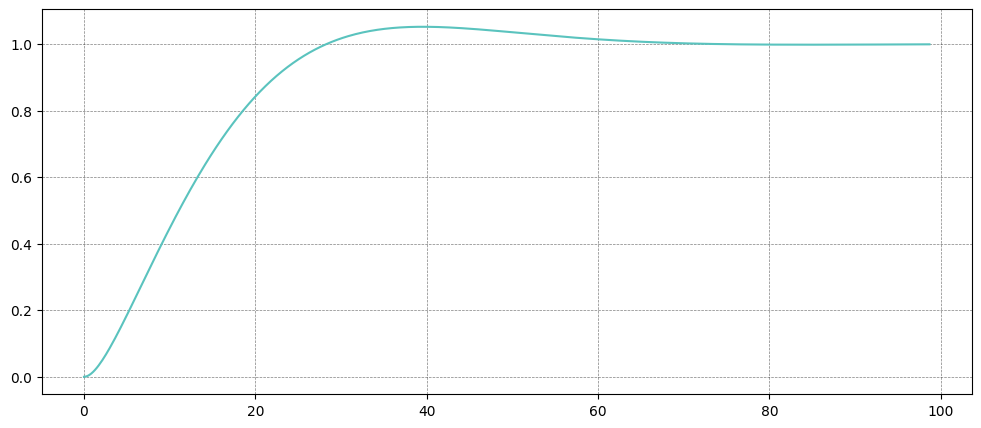

In [36]:
#Resposta ao degrau unitário:
sol = ct.step_response(mf)

#Plot da curva:
plt.figure()
plt.plot(sol[0], sol[1], color='C2')
plt.show()

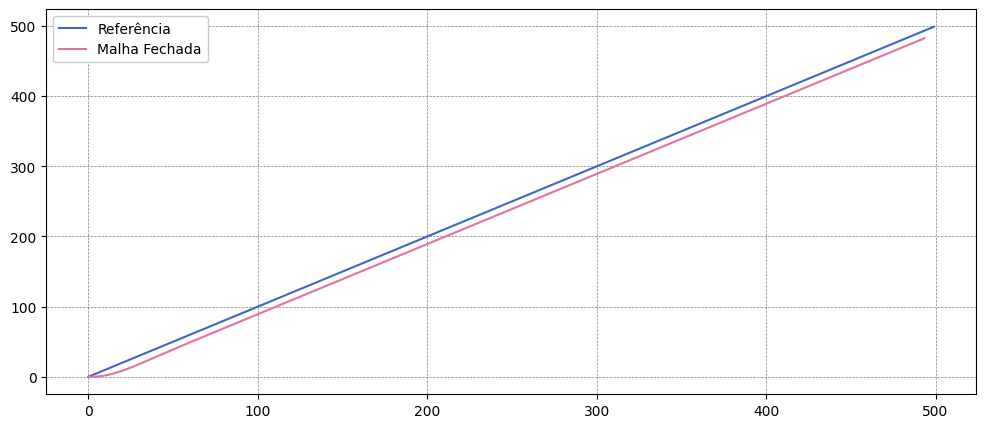

In [35]:
#Resposta a rama unitária:
sol = ct.step_response(mf/s)

#Plot da curva:
plt.figure()
plt.plot(np.arange(0,500), np.arange(0,500), label='Referência')
plt.plot(sol[0], sol[1], label='Malha Fechada')
plt.legend()
plt.show()